## Testing Julia for GAIA

using the julia language for GAIA analaysis <br>

1. Testing the optimization of the dbscan
2. Testng Affinity propagation ... not yet
3. Testing the metric


In [1]:
using PyCall
using DataFrames
using Statistics

using Clustering
@pyimport scipy.spatial as sp

using Statistics
using Distances
using Random

push!(LOAD_PATH,"/home/stephane/Science/cluster/GAIA/master/src")
using GaiaClustering

import PyPlot; const plt = PyPlot

@pyimport astropy.io.votable as votable
# @pyimport matplotlib.pyplot as plt

## directory
rootdir = "/home/stephane/Science/cluster/GAIA"
wdir    = "/home/stephane/Science/cluster/GAIA/products"

cd(wdir)

In [2]:
## Main program

voname = "test.vot"

data       = read_votable(voname)
df         = filter_data(data)
dfcart     = add_cartesian(df)
blck       = [[1,2,3],[4,5], [6,7,8]]
wghtblck   = [4.0,5.0,1.0]
norm       = "identity"

dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false) 

## Votable test.vot read
## Filtering done ...
## Stars selected: 5382
## Cartesian transformation done ...
## Normalization identity done...
### [1pc,1pc,1pc,1km/s,1km/s,1mag,1mag] equivalent to [0.398015, 0.398015, 0.398015, 0.497519, 0.497519, 0.0995037, 0.0995037, 0.0995037]


(GaiaClustering.Df(5382, [154.021 664.539 … 633.798 94.8234; 0.972147 4.59243 … -3.45979 -0.532369; … ; 0.151565 0.0636172 … 0.0593695 0.0927025; 0.0210137 0.0497518 … 0.0409578 -0.00017973], [279.414 279.449 … 278.74 278.731; -33.714 -33.8748 … -34.5625 -34.5608; … ; 17.9101 11.092 … 15.4264 18.263; 19.6445 12.2314 … 16.4346 19.1929], [0.329563 0.0234406 … 0.0389376 0.57341; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]), [0.398015, 0.398015, 0.398015, 0.497519, 0.497519, 0.0995037, 0.0995037, 0.0995037])

In [3]:
function _clusters(data , epsilon, leaf , minneigh, mincluster)
    eps = epsilon
    leafsize = leaf
    min_neighbors = minneigh
    min_cluster_size = mincluster

    res = dbscan(data , eps , leafsize = leaf, min_neighbors = minneigh, min_cluster_size=mincluster)
    
    label = Vector{Vector{Int}}()
    
    for cl in res
        indx = cl.core_indices
        append!(indx, cl.boundary_indices) 
        push!(label,indx)
    end
    return(label)
end

## Clustering ..
println("## Starting Clustering ...")

###########################3
eps = 4.0

println("ϵ : $eps")

dftemp = copy1(dfcartnorm)
println("## dbscan..")
labels = clusters(dftemp.data , eps , 20, 5, 20)
println("### done ...")



println("## Computing metric ...")
# println(labels)
println("spatial2d")
q2d = metric(dfcart, labels, "spatial2d" , 2.0 , 20.0, 20 )
println(q2d)
println("spatial3d")
q3d = metric(dfcart, labels, "spatial3d" , 5.0 , 20.0, 20 )
println(q3d)
println("velocity")
qv = metric(dfcart, labels, "velocity" , 3.0 , 30.0, 20 )
println(qv)
println("HRD")
qp, qa = metric(dfcart, labels, "HRD" )
println(qp)
println(qa)

indx = labels[2]

nlab = 0
for ilab in labels
    nlab += 1
    println("Label:",nlab," - :",length(ilab))
end



## Starting Clustering ...
ϵ : 4.0
## dbscan..
### done ...
## Computing metric ...
spatial2d
Any[(0.689356, 0.591577), (1.59041, 1.09209), (1.47999, 1.2168)]
spatial3d
Any[(0.160566, 1.06846), (0.604327, 1.48441), (0.253115, 1.85702)]
velocity
Any[(1.07711, 0.712388), (1.39419, 0.813519), (3.39623, 1.76522)]
HRD
## Voronoi tesselation done.
## Voronoi tesselation done.
## Voronoi tesselation done.
Any[(0.280274, 3.31988), (2.31997, 0.048082), (2.81827, 0.017256)]
Any[(0.364306, 1.60663), (1.54615, 0.154267), (2.43635, 0.0164553)]
Label:1 - :20
Label:2 - :24
Label:3 - :130


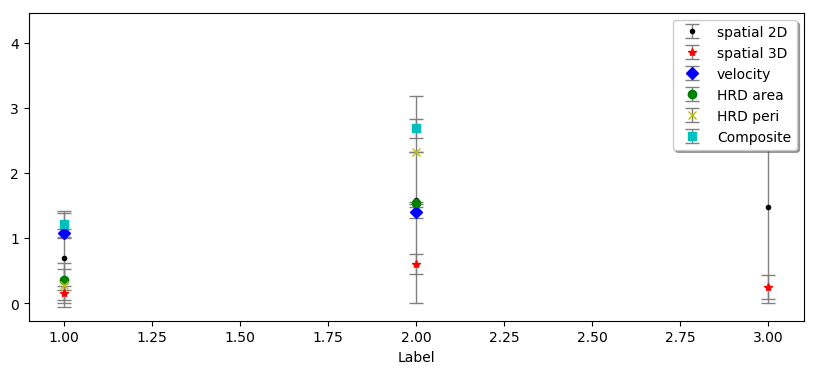

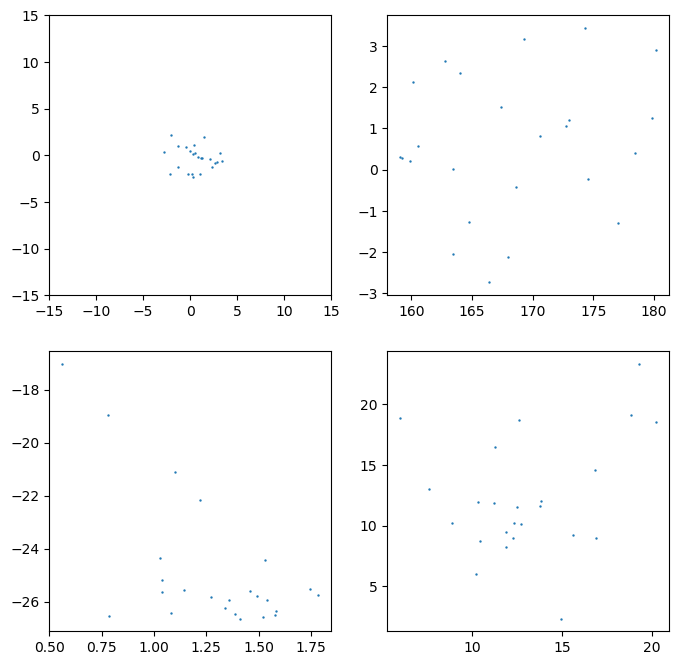

In [8]:
## push Q, Q_st
function pushQ(qc)
    q1  = []
    q1d = []
    for q in qc
        push!(q1,q[1])
        push!(q1d,q[2]/10) 
    end
    return(q1, q1d)
end
    
## metric of the labels
plt.figure(figsize=(10.0,4.0))

xlabel = 1:nlab

qq2d  , qqd2d = pushQ(q2d)
qq3d  , qqd3d = pushQ(q3d)
qqv  , qqdv = pushQ(qv)
qqa  , qqda = pushQ(qa)
qqp  , qqdp = pushQ(qp)


## composite
Qcp = (3.0 .* qq2d .+ qq3d .+ 3.0 .* qqv .+ qqa .+ qqp) ./ 5
Qdcp = (3.0 .* qqd2d .+ qqd3d .+ 3.0 .* qqdv .+ qqda .+ qqdp) ./ 5 


plt.errorbar(xlabel, qq2d, qq2d, label="spatial 2D",fmt=".k", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qq3d, qqd3d, label="spatial 3D",fmt="*r", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqv, qqdv, label="velocity",fmt="Db", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqa, qqda, label="HRD area",fmt="og", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqp, qqdp, label="HRD peri",fmt="xy", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, Qcp, Qdcp, label="Composite",fmt="sc", ecolor="gray", lw=1, capsize=5)
plt.legend(loc="upper right", shadow=true)
plt.xlabel("Label")
plt.show()

plt.figure(figsize=(8.0,8.0))

plt.subplot(2, 2, 1 , xlim = [-15,15] , ylim = [-15,15])
x = dfcart.data[2,indx]
y = dfcart.data[3,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 2)
x = dfcart.data[1,indx]
y = dfcart.data[2,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 3)
x = dfcart.data[7,indx]
y = -dfcart.data[6,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 4)
x = dfcart.data[4,indx]
y = -dfcart.data[5,indx]
plt.scatter(x, y , s = 0.5 )


plt.show()